In [ ]:
import numpy as np
import pandas as pd
import random

from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical 

from keras.callbacks import ModelCheckpoint 

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
import torch
import torchvision
import torchvision.transforms as T # data augmentation
import torchvision.models as models # to get pretrained models
import torch.nn as nn # to build NN, criterion
import torch.optim as optim # optimizer

# plotting and evaluation
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix # performance evaluation

# Datapipe Line
import pandas as pd # read csv
from imblearn.over_sampling import RandomOverSampler as ROS # training data oversampling
from sklearn.model_selection import train_test_split # splitting dataframes
from torch.utils.data import Dataset, DataLoader # data pipeline

# utils
import numpy as np
import os
import random
import torch.nn.functional as F # softmax
from tqdm import tqdm # progress visualisation

# Setting device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# For reproducibility
RANDOM_SEED = 42 

def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed(RANDOM_SEED)

Random seed set as 42


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


TypeError: ignored

In [ ]:
ls -1ha kaggle.json

kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning이 발생하지 않도록 해줍니다.
!chmod 600 ~/.kaggle/kaggle.json
# 내가 참가한 대회 리스트 확인
!kaggle competitions list

In [ ]:
! kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.20G/5.20G [02:29<00:00, 40.6MB/s]
100% 5.20G/5.20G [02:29<00:00, 37.3MB/s]


In [ ]:
!ls

gdrive	kaggle.json  sample_data  skin-cancer-mnist-ham10000.zip


In [ ]:
!unzip skin-cancer-mnist-ham10000.zip

캐글 데이터 저장//


1. 데이터 확인

In [ ]:
data_check = pd.read_csv("./HAM10000_metadata.csv")
data_check.head()

FileNotFoundError: ignored

In [ ]:
data = pd.read_csv('./hmnist_28_28_RGB.csv')
data.head()
classes = {0: ('akiec', 'Actinic keratoses'),  
           1:('bcc' , ' basal cell carcinoma'), 
           2:('bkl', 'benign keratosis-like lesions'), 
           3: ('df', 'dermatofibroma'),
           4: ('nv', ' melanocytic nevi'), 
           5: ('vasc', ' pyogenic granulomas and hemorrhage'), 
           6: ('mel', 'melanoma'),
           }
CLASSES = [classes[idx][0] for idx in range(len(classes))] # abbreviated form of classes
CLASSES_FULL = [classes[idx][1] for idx in range(len(classes))] # Full name of classes
CLASSES, CLASSES_FULL

(['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc', 'mel'],
 ['Actinic keratoses',
  ' basal cell carcinoma',
  'benign keratosis-like lesions',
  'dermatofibroma',
  ' melanocytic nevi',
  ' pyogenic granulomas and hemorrhage',
  'melanoma'])

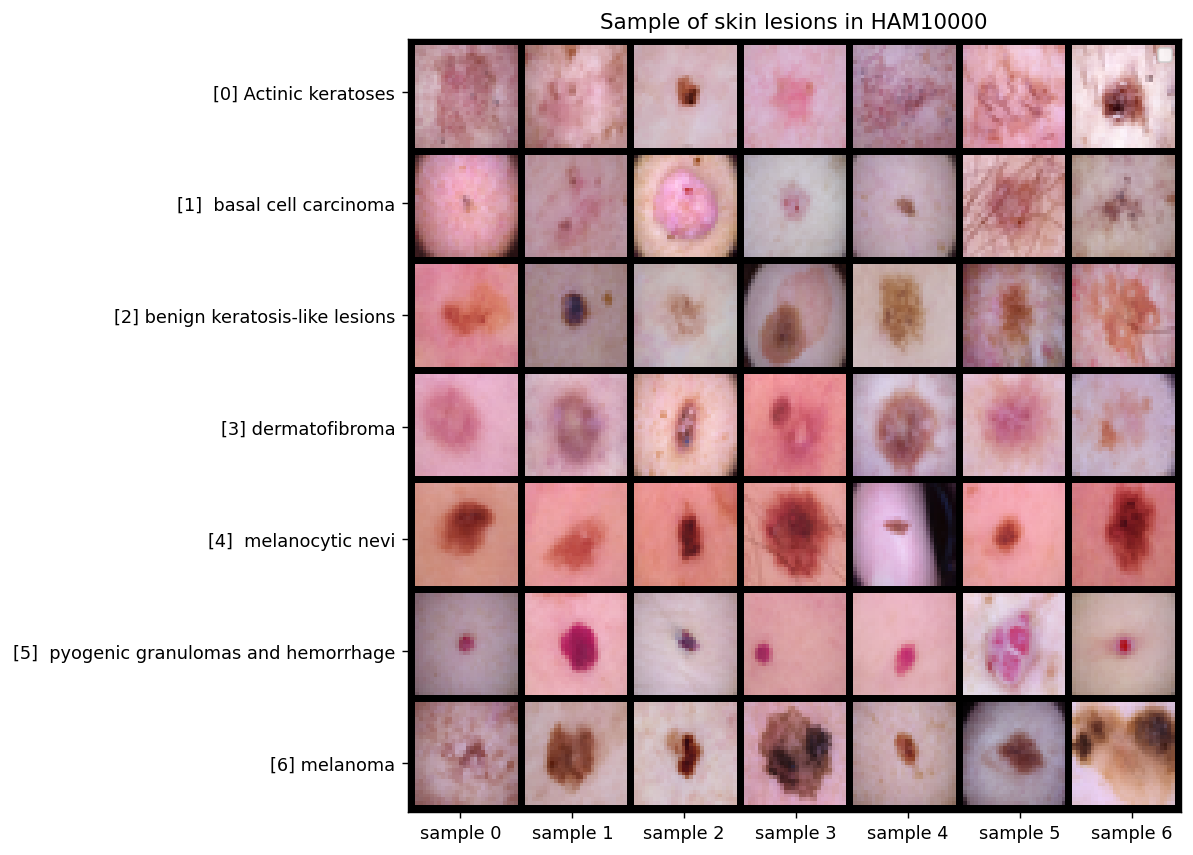

In [ ]:
sample_images = []
N = len(CLASSES) # number of samples per class
for class_ in classes.keys():
    image_idxs = data.label==class_
    N_ = len(data[image_idxs])
    chosen = random.sample(list(np.arange(N_)), k= N) # creating random 7 samples per class
    images = np.asarray(data[image_idxs].iloc[chosen,:-1])# grabing those random 7 samples
    
    for img in images:
        sample_images.append(torch.tensor(img.reshape(28,28,3)).permute(2,0,1)) # obtaining one image at a time 
        
s = torch.stack(sample_images) # stack all images, convert to torch.tensor for grid
grid = torchvision.utils.make_grid(s, nrow=N, ncol=N) # create grid with same rows and cols

plt.figure(figsize=(8,8), dpi=(128)) # plot the grid
plt.imshow(grid.permute(1,2,0))
plt.xticks(np.linspace(14,grid.shape[2]-14,7), labels=[f'sample {idx}' for idx in range(N)])
plt.yticks(np.linspace(14,grid.shape[1]-14,7), labels=[f'[{idx}] {cls_}' for idx, cls_ in enumerate(CLASSES_FULL)])
plt.title('Sample of skin lesions in HAM10000')
plt.legend(CLASSES_FULL)
plt.show(block='off')

In [ ]:
lr = 0.001
bs = 256 # On P100, 512 is okay for resnet32 and resnet50, bs 256 is okay for densenet121 and densenet201
EPOCHS = 40 # number of training epochs in total
FT_EPOCHS = 5 # first epochs to fine tune classifier head only, after that end to end finetuning begins
LR_MIN = 1e-6 # minimum learning rate, below that, early training stopping occurs

highest_acc = 0.80 # Manually set for now

# Choose CNN backbone
CNNS = ['resnet34', 'resnet50', 'densenet121', 'densenet201']
CHOSEN_MODEL = CNNS[2] # desnenet121 performs best

# Flags
SAVE_CHECKPOINT = True
SAVE_HIGHEST = True

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3249: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if (await self.run_code(code, result,  async_=asy)):


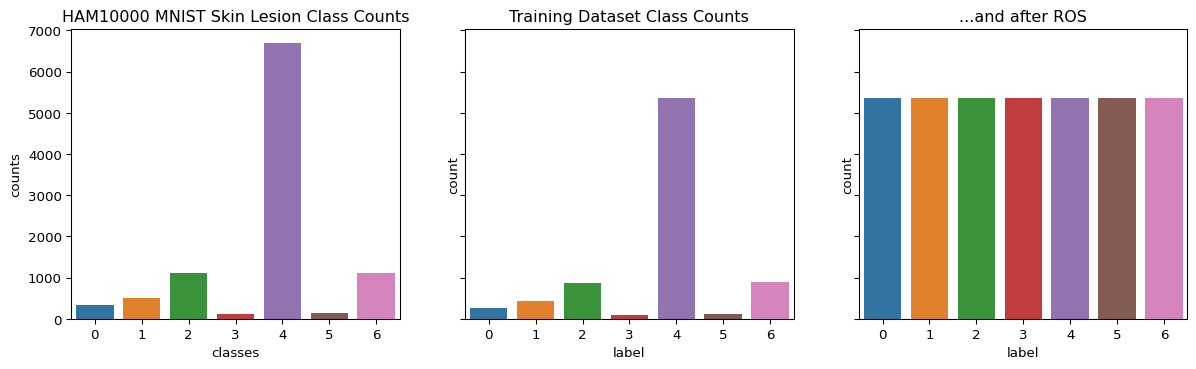

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize=(15,4), dpi=(96), sharex=True, sharey=True)

# Original dataset
x = data.drop(labels='label', axis=1) # drop the label column
y = data.label # get the label
# Plotting count
sns.countplot(x=data['label'], ax=ax[0])
ax[0].set(xlabel='classes', ylabel='counts')
ax[0].title.set_text('HAM10000 MNIST Skin Lesion Class Counts')


# Split original dataframe to training and testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# Plot number of samples in train split
x_train_ = x_train.copy()
x_train_.insert(0, 'label', value=y_train.values)
train_df_ = x_train_
sns.countplot(x=train_df_['label'], ax=ax[1])
ax[1].title.set_text('Training Dataset Class Counts')

# Create over sampler, and over sample ONLY the TRAIN dataframe
oversampler = ROS()
x_train, y_train = oversampler.fit_resample(x_train, y_train)

# Combine train image and label dataframe as one dataframe because my dataset requires it
x_train.insert(0, 'label', value=y_train.values)
train_df = x_train

# Combine test image and label dataframe as one dataframe because my dataset requires it
x_test.insert(0, 'label', value=y_test.values)
test_df = x_test

# Print number of samples in each train/test splits
len(train_df), len(test_df)

# Plot number of samples in train split (thats oversampled); all classes should have same number of counts
sns.countplot(x=train_df['label'], ax=ax[2])
ax[2].title.set_text('...and after ROS')
plt.show(block='off')

In [ ]:
class HAM10KDS(Dataset): # custom dataset
    def __init__(self, df, transforms=None, selective=True, OR=4, normalised=True):
        self.data = df # the dataframe containing the image
        self.y = self.data.label # label y
        self.x = self.data.drop(labels='label', axis=1) # drop the label, get images
        
        # Reshape the entire image array into N x height x width x RGB channel. N = number of samples
        self.x = np.asarray(self.x).reshape(-1, 28, 28,3)
        
        # Calculate the RGB stats for normalisation, and convert to tensor.
        self.mean = torch.tensor([np.mean(self.x[:, :, :, channel]) for channel in range(3)]).reshape(1, 3, 1, 1) 
        self.std = torch.tensor([np.std(self.x[:, :, :, channel]) for channel in range(3)]).reshape(1, 3, 1, 1)  
        
        # Convert images to torch tensor for transforms and training on GPU. Images will be moved to GPU outside dataloader.
        self.x = torch.tensor(self.x, dtype=torch.float32).permute(0, 3, 1, 2)
        
        # Normalise the images with the stats calculated
        if normalised==True:
            self.x -= self.mean
            self.x /= self.std
        print('images are normalised')
        
        self.resize = T.Resize((28*4, 28*4)) # Increase images by 4 in both dimension.

        self.OR = OR # the label of the over represented class
        self.tf = transforms # the input list of transforms
        self.selective = selective # flag to apply transform to under rep classes only
        
    def __len__(self):
        return len(self.data) # number of samples in dataset
    
    def __getitem__(self,idx):
        label = torch.tensor(self.y.iloc[idx]) # get label of image and convert to torch tensor
        
        img = self.x[idx] # get the image from the big tensor
        img = self.resize(img) # upsize the image
        
        # Applying transforms
        if self.tf!=None:
            if self.selective==True: # Can choose to NOT apply augmentation on over rep classes
                if label.item()!=self.OR: 
                    img = self.tf(img)
            else: # Or just apply aug to ALL classes and samples
                img = self.tf(img)
                                
        return img, label
        

In [ ]:
class CNN(nn.Module): # custom CNN model
    
    def __init__(self, num_classes, model='resnet50'):
        super(CNN, self).__init__()
        
        self.num_classes = num_classes
        print(f'There are {self.num_classes} classes.')
        
        self.chosen_model = model
        
        
        # Choosing backbone CNN
        
        if self.chosen_model=='resnet34':
            
            self.model = models.resnet34(pretrained=True)
            
            self.classifier = nn.Sequential(
                nn.Dropout(p=0.1), # regularisation
                
                # Common practise to set nn.Linear with no bias if using batchnorm after it.
                # As batchnorm normalises activitations from nn.Linear, it also removes the bias from nn.Linear,
                # and it adds its own bias term. Thus, nn.Linear bias term is redundant.
                
                nn.Linear(self.model.fc.in_features, 256, bias=False), 
                nn.ReLU(),
                nn.BatchNorm1d(256),

                nn.Linear(256, 128, bias=False),
                nn.ReLU(),
                nn.BatchNorm1d(128),

                nn.Linear(128, self.num_classes, bias=False),
                nn.BatchNorm1d(self.num_classes), 
            )
            self.model.fc = self.classifier
            
        elif self.chosen_model=='densenet121':
            
            self.model = models.densenet121(pretrained=True)
            
            self.classifier = nn.Sequential(
                nn.Dropout(p=0.1), # regularisation
                
                # Common practise to set nn.Linear with no bias if using batchnorm after it.
                # As batchnorm normalises activitations from nn.Linear, it also removes the bias from nn.Linear,
                # and it adds its own bias term. Thus, nn.Linear bias term is redundant.
                
                nn.Linear(self.model.classifier.in_features, 256, bias=False), 
                nn.ReLU(),
                nn.BatchNorm1d(256),

                nn.Linear(256, 128, bias=False),
                nn.ReLU(),
                nn.BatchNorm1d(128),

                nn.Linear(128, self.num_classes, bias=False),
                nn.BatchNorm1d(self.num_classes), 
            )
            
            self.model.classifier = self.classifier
            
        print(f'{self.chosen_model} created')
        
        model_parameters = filter(lambda p: p.requires_grad, self.model.parameters())
        params = sum([np.prod(p.size()) for p in model_parameters])
        print(f'Model has {params} trainable params.')

    def forward(self, x):
        
        return self.model(x)

In [ ]:
# Image augmentation only for training
tf = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.RandomAffine(degrees=15, 
                   translate=(0.1, 0.1), 
                   scale=(0.9,1.0), 
                   shear=(10))
                   
])

# Create dataset and dataloader for train and test
train_ds = HAM10KDS(train_df, tf, selective=False)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, pin_memory=True, num_workers=2)

test_ds = HAM10KDS(test_df)
test_dl = DataLoader(test_ds, batch_size=bs, shuffle=False, pin_memory=True, num_workers=2)

print('There are ', len(train_ds),' training samples, ', len(test_ds), ' testing samples.')

# Create model with chosen CNN backbone
model = CNN(len(CLASSES), model=CHOSEN_MODEL).to(DEVICE)

# Freezing pretrained CNN backbone for classifier head fine tuning
for p in model.parameters():
    p.requires_grad=False
    
for p in model.classifier.parameters():
    p.requires_grad=True

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.1)

# Weights for weighted cross entropy loss
#class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0]).to(DEVICE)
#criterion = nn.CrossEntropyLoss(weight=class_weights) # multi class cross enropty loss with softmax built in

# Loss function. Have one for train and test/eval just in case train loss is different.
criterion = nn.CrossEntropyLoss()
eval_criterion = nn.CrossEntropyLoss()

# Reduce lr to 10 percent if test accuracy doesnt improve by 1%
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, threshold=0.0001, threshold_mode='rel', 
                                                       cooldown=0, min_lr=0, eps=1e-08, verbose=True) 

images are normalised
images are normalised
There are  37569  training samples,  2003  testing samples.
There are 7 classes.


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

densenet121 created
Model has 7250446 trainable params.


In [ ]:
# Test run to check if forward pass works
# test_i = torch.randn((1,3,28*2,28*2), dtype=torch.float32).to(DEVICE)
# out = model(test_i)

In [ ]:
train_acc = []
train_losses = []

test_acc = []
test_losses = []

lrs = []

# For warmup
lr0 = lr*0.01

lr_step = (lr-lr0)/(len(train_dl)-1) # lr step for slow warm up from lr0 to lr 

print(f'Highest acc to beat: {highest_acc}')
best_acc = 0.90*highest_acc # use to decide whether to save a run 

for epoch in range(EPOCHS):
        loader = tqdm(train_dl)
        losses = [] # logs avg loss per epoch
        accs = [] # logs avg acc per epoch
        correct = 0 # counts how many correct predictions
        count = 0 # counts how many samples
        
        if epoch>0:
            lrs+= [optimizer.param_groups[0]['lr']]*len(train_dl) # track lr after warm up
        
        if epoch==FT_EPOCHS:
            for p in model.parameters():
                p.requires_grad = True
            print('End to End Fine Tuning Begins')

        model.train()
        for bidx, (images, labels) in enumerate(loader):
            
            # Warm up, slowly increase fomr lr0 to lr in first epoch
            if epoch==0:
                    
                lr_ = lr0 + lr_step*bidx

                for op in optimizer.param_groups:
                    op['lr'] = lr_

                lrs.append(optimizer.param_groups[0]['lr']) # track lr

            images = images.to(DEVICE) # move to gpu
            labels = labels.to(DEVICE)
                
            score = model(images)
            loss = criterion(score, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                pred = torch.argmax(score, -1).detach() # need to detach else bug
                correct += (pred==labels).sum() # count how many correct
                count += len(labels)
                acc = correct/count # accumated accuracy
                
                losses.append(loss.item())
                accs.append(acc)
                
                loader.set_description(f'TRAIN | epoch {epoch+1}/{EPOCHS} | acc {acc:.4f} | loss {loss.item():.4f}')
                
        train_acc.append(acc)
        train_losses.append(torch.tensor(losses).mean().item())
                
        model.eval()
        with torch.no_grad():
            
            loader = tqdm(test_dl)
            
            losses = [] # logs loss per minibatch
            accs = [] # logs running acc throughout one epoch
            
            correct = 0 # counts how many correct predictions in one epoch
            count = 0 # counts how many samples seen in one epoch
            
            for bidx, (images, labels) in enumerate(loader):
                images = images.to(DEVICE) # move to gpu
                labels = labels.to(DEVICE)

                score = model(images)
                loss = eval_criterion(score, labels)
                
                pred = torch.argmax(score, -1).detach() # need to detach else bug
                correct += (pred==labels).sum() # count how many correct
                count += len(labels)

                acc = correct/count # accumated accuracy
                loader.set_description(f'TEST | epoch {epoch+1}/{EPOCHS} | acc {acc:.4f} | loss {loss.item():.4f}')
                
                losses.append(loss.item())
                accs.append(acc)

        test_acc.append(acc)
        test_losses.append(torch.tensor(losses).mean().item())
        
        scheduler.step(torch.tensor(acc)) # reduce lr if test acc does not improve
        
        if SAVE_CHECKPOINT==True:
            if test_acc[-1]>best_acc:
                best_acc = test_acc[-1].item()

                checkpoint = {
                    'model': model,
                    'losses': [train_losses, test_losses],
                    'accs': [train_acc, test_acc],
                    'lrs': lrs,
                    'best_acc': best_acc,
                    'last_epoch_trained': epoch,
                }
                
                if best_acc > highest_acc and SAVE_HIGHEST==True:
                    old_highest_acc = highest_acc
                    highest_acc = best_acc
                    torch.save(highest_acc, 'highest_acc.pt')
                    print(f'HIGHEST ACCURACY SURPASSED from {old_highest_acc} to {highest_acc}') # save highest achieving model evahhh (yayyy! ^.^)
                    torch.save(checkpoint, f'{highest_acc:.4f} checkpoint.pt')

                torch.save(checkpoint, 'checkpoint.pt')
                print(f'Checkpointed with {best_acc:.4f} best acc')
            
        if optimizer.param_groups[0]['lr']<LR_MIN:
            print(f'EARLY STOPPING! LR below {LR_MIN}')
            break

Highest acc to beat: 0.8


TRAIN | epoch 1/40 | acc 0.4793 | loss 1.2183: 100%|██████████| 147/147 [01:13<00:00,  2.00it/s]
TEST | epoch 1/40 | acc 0.3834 | loss 1.5953: 100%|██████████| 8/8 [00:02<00:00,  3.86it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
TRAIN | epoch 2/40 | acc 0.6394 | loss 1.0126: 100%|██████████| 147/147 [01:03<00:00,  2.31it/s]
TEST | epoch 2/40 | acc 0.4428 | loss 1.4234: 100%|██████████| 8/8 [00:02<00:00,  3.85it/s]
TRAIN | epoch 3/40 | acc 0.6791 | loss 0.9534: 100%|██████████| 147/147 [01:09<00:00,  2.12it/s]
TEST | epoch 3/40 | acc 0.4873 | loss 1.3525: 100%|██████████| 8/8 [00:02<00:00,  3.83it/s]
TRAIN | epoch 4/40 | acc 0.7019 | loss 0.8113: 100%|██████████| 147/147 [01:07<00:00,  2.18it/s]
TEST | epoch 4/40 | acc 0.5062 | loss 1.2850: 100%|██████████| 8/8 [00:02<

End to End Fine Tuning Begins


TRAIN | epoch 6/40 | acc 0.8263 | loss 0.3571: 100%|██████████| 147/147 [01:49<00:00,  1.34it/s]
TEST | epoch 6/40 | acc 0.6990 | loss 0.8295: 100%|██████████| 8/8 [00:02<00:00,  3.68it/s]
TRAIN | epoch 7/40 | acc 0.9067 | loss 0.2666: 100%|██████████| 147/147 [01:49<00:00,  1.34it/s]
TEST | epoch 7/40 | acc 0.7309 | loss 0.7221: 100%|██████████| 8/8 [00:02<00:00,  3.66it/s]


Checkpointed with 0.7309 best acc


TRAIN | epoch 8/40 | acc 0.9293 | loss 0.3157: 100%|██████████| 147/147 [01:49<00:00,  1.34it/s]
TEST | epoch 8/40 | acc 0.7678 | loss 0.6187: 100%|██████████| 8/8 [00:02<00:00,  3.66it/s]


Checkpointed with 0.7678 best acc


TRAIN | epoch 9/40 | acc 0.9436 | loss 0.1715: 100%|██████████| 147/147 [01:49<00:00,  1.34it/s]
TEST | epoch 9/40 | acc 0.7339 | loss 0.7953: 100%|██████████| 8/8 [00:02<00:00,  3.64it/s]
TRAIN | epoch 10/40 | acc 0.9497 | loss 0.1999: 100%|██████████| 147/147 [01:49<00:00,  1.34it/s]
TEST | epoch 10/40 | acc 0.7399 | loss 0.7412: 100%|██████████| 8/8 [00:02<00:00,  3.71it/s]
TRAIN | epoch 11/40 | acc 0.9563 | loss 0.1839: 100%|██████████| 147/147 [01:49<00:00,  1.34it/s]
TEST | epoch 11/40 | acc 0.7693 | loss 0.6751: 100%|██████████| 8/8 [00:02<00:00,  3.67it/s]


Checkpointed with 0.7693 best acc


TRAIN | epoch 12/40 | acc 0.9603 | loss 0.1607: 100%|██████████| 147/147 [01:49<00:00,  1.34it/s]
TEST | epoch 12/40 | acc 0.7414 | loss 0.7130: 100%|██████████| 8/8 [00:02<00:00,  3.62it/s]
TRAIN | epoch 13/40 | acc 0.9655 | loss 0.1583: 100%|██████████| 147/147 [01:49<00:00,  1.34it/s]
TEST | epoch 13/40 | acc 0.7948 | loss 0.5872: 100%|██████████| 8/8 [00:02<00:00,  3.66it/s]


Checkpointed with 0.7948 best acc


TRAIN | epoch 14/40 | acc 0.9647 | loss 0.1402: 100%|██████████| 147/147 [01:52<00:00,  1.30it/s]
TEST | epoch 14/40 | acc 0.7678 | loss 0.6654: 100%|██████████| 8/8 [00:02<00:00,  3.67it/s]
TRAIN | epoch 15/40 | acc 0.9702 | loss 0.1943: 100%|██████████| 147/147 [01:49<00:00,  1.34it/s]
TEST | epoch 15/40 | acc 0.7888 | loss 0.6693: 100%|██████████| 8/8 [00:02<00:00,  3.63it/s]
TRAIN | epoch 16/40 | acc 0.9742 | loss 0.0976: 100%|██████████| 147/147 [01:51<00:00,  1.32it/s]
TEST | epoch 16/40 | acc 0.7454 | loss 0.7256: 100%|██████████| 8/8 [00:02<00:00,  3.64it/s]
TRAIN | epoch 17/40 | acc 0.9704 | loss 0.1005: 100%|██████████| 147/147 [01:51<00:00,  1.32it/s]
TEST | epoch 17/40 | acc 0.7703 | loss 0.6780: 100%|██████████| 8/8 [00:02<00:00,  3.61it/s]


Epoch 00017: reducing learning rate of group 0 to 1.0000e-04.


TRAIN | epoch 18/40 | acc 0.9857 | loss 0.0554:  52%|█████▏    | 76/147 [00:59<00:53,  1.32it/s]

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(18,4), dpi=(96))

# Plotting accuracies
ax[0].plot(torch.stack(train_acc).cpu())
ax[0].plot(torch.stack(test_acc).cpu())
ax[0].plot([highest_acc]*(len(train_acc)))
ax[0].scatter(torch.argmax(torch.tensor(test_acc)).item(), torch.tensor(test_acc).max().item(), s=128, c='red', marker='*')
           
ax[0].title.set_text('Accuracy')
ax[0].set(xlabel='epochs', ylabel='accuracy')
ax[0].legend(['train', 'val', f'highest {highest_acc:.4f}', f'best {best_acc:.4f}'], loc='upper left')

# Plotting losses
ax[1].plot(train_losses)
ax[1].plot(test_losses)
ax[1].plot([torch.tensor(test_losses).min()]*len(test_losses))
ax[1].scatter(torch.argmin(torch.tensor(test_losses)).item(), torch.tensor(test_losses).min().item(), s=128, c='red', marker='*')


ax[1].title.set_text('Loss')
ax[1].set(xlabel='epochs', ylabel='loss')
ax[1].legend(['train', 'val', f'lowest {torch.tensor(test_losses).min().item():.4f}', f'best {torch.tensor(test_losses).min().item():.4f}'], loc='upper left')

# Plot learning rate
ax[2].plot(lrs)
ax[2].title.set_text('Learning Rate')
ax[2].set(xlabel='steps', ylabel='learning rate')

plt.show(block='off')

2.


In [ ]:
data1 = pd.read_csv('./hmnist_28_28_RGB.csv')

데이터 분리

In [ ]:
def prepare_for_train_test(X, Y):
    # Splitting into train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
    
    # Prepare data for training and testing the model
    train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 10,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = 'nearest')
    train_datagen.fit(X_train)
    test_datagen = ImageDataGenerator(rescale = 1./255)
    test_datagen.fit(X_test)
    return X_train, X_test, Y_train, Y_test

모델

In [ ]:
def create_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
    print(model.summary())
    return model;

training

In [ ]:
def train_model(model, X_train, Y_train, EPOCHS=25):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, 
                           mode='auto')
                               #, restore_best_weights=True)
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, 
                              verbose=1, mode='auto')
    
    history = model.fit(X_train,
                        Y_train,
                        validation_split=0.2,
                        batch_size = 64,
                        epochs = EPOCHS,
                        callbacks = [reduce_lr, early_stop])
    return history

test model

In [ ]:
def test_model(model, X_test, Y_test):
    model_acc = model.evaluate(X_test, Y_test, verbose=0)[1]
    print("Test Accuracy: {:.3f}%".format(model_acc * 100))
    y_true = np.array(Y_test)
    y_pred = model.predict(X_test)
    y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
    clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
    print(clr)
    
    sample_data = X_test[:15]
    plt.figure(figsize=(22, 12))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(sample_data[i])
        plt.title(label_mapping[y_true[i][0]] + '|' + label_mapping[y_pred[i]])
        plt.axis("off")
    plt.show() 

training curve plot

In [ ]:
def plot_model_training_curve(history):
    fig = make_subplots(rows=1, cols=2, subplot_titles=['Model Accuracy', 'Model Loss'])
    fig.add_trace(
        go.Scatter(
            y=history.history['accuracy'], 
            name='train_acc'), 
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_accuracy'], 
            name='val_acc'), 
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['loss'], 
            name='train_loss'), 
        row=1, col=2)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_loss'], 
            name='val_loss'), 
        row=1, col=2)
    fig.show()